In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from einops import rearrange

In [6]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
from jax.config import config
config.update("jax_enable_x64", True)

In [8]:
import sys
sys.path.append("../")
from lensing_sim.lensing import LensingSim

In [183]:
cmap = 'RdBu_r'

## Observational parameters

In [184]:
# Don't worry about these
exposure = 1610.0
n_xy = 256
pixel_size = 0.1 * 64 / n_xy
mag_zero=25.5
mag_iso=310.5
mag_s = 26.5
fwhm_psf = 0.18

coordinate_limit = pixel_size * n_xy / 2.0
f_iso = LensingSim._mag_to_flux(mag_iso, mag_zero)
S_tot = LensingSim._mag_to_flux(mag_s, mag_zero)

observation_dict = {
    "n_x": n_xy,
    "n_y": n_xy,
    "theta_x_lims": (-coordinate_limit, coordinate_limit),
    "theta_y_lims": (-coordinate_limit, coordinate_limit),
    "exposure": exposure,
    "f_iso": f_iso,
}

### Can play around with changing these ###

# Size of source
theta_s_e = 0.8

# Redshift (distance) of source and lens
global_dict = {"z_s": 1., "z_l": 0.2}

# theta_x_0 and theta_y_0 are the position of lens, theta_E is its size, q is its ellipticity
hst_param_dict = {"profile": "SIE", "theta_x_0": 0.12, "theta_y_0": -0.2, "theta_E": 2.15, "q": 0.8}

###########################################

src_param_dict = {"profile": "Sersic", "theta_x_0": 0., "theta_y_0": 0., "S_tot": S_tot, "theta_e": theta_s_e,"n_srsc": 1}    

## MNIST download

In [185]:
from urllib import request
import gzip
import pickle

filename = [
["training_images","../data/train-images-idx3-ubyte.gz"],
["test_images","../data/t10k-images-idx3-ubyte.gz"],
["training_labels","../data/train-labels-idx1-ubyte.gz"],
["test_labels","../data/t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("../data/mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("../data/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

# download_mnist()
# save_mnist()

mnist_sq = rearrange(load()[0], 'b (h w) -> b h w', h=28)

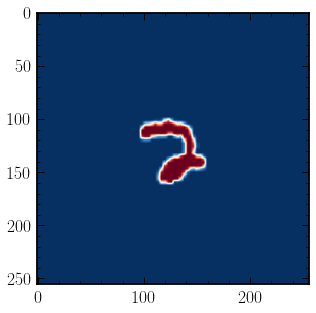

In [186]:
from skimage.transform import rescale, resize, downscale_local_mean

idx_image = np.random.randint(1000)
im_source = resize(np.pad(mnist_sq[idx_image], (28, 28)), (n_xy, n_xy),
                       anti_aliasing=True)

plt.imshow(im_source, cmap=cmap, vmin=0, vmax=1)

## Real galaxies 

In [187]:
# import galsim

In [188]:
# ind = np.random.randint(2000)  # 4156

In [189]:
# im_size = n_xy
# pix_scale = 0.1 * 64 / im_size

# bp_file = os.path.join(galsim.meta_data.share_dir, 'wfc_F814W.dat.gz')
# bandpass = galsim.Bandpass(bp_file, wave_type='ang').thin().withZeropoint(25.94)

# psf = galsim.OpticalPSF(diam=2.4, lam=1000.) # bigger than HST F814W PSF.

# cosmos_cat = galsim.COSMOSCatalog(sample='23.5', dir='/n/holyscratch01/dvorkin_lab/smsharma/COSMOS_23.5_training_sample/')

# im = cosmos_cat.makeGalaxy(ind, gal_type='real', noise_pad_size=im_size * pix_scale)

# real_gal = galsim.Convolve(im, psf)
# im_real = galsim.Image(im_size, im_size)
# im_real = real_gal.drawImage(image=im_real, scale=pix_scale)

# im_source = im_real.array  #  nn.sigmoid(im_real.array)

# plt.imshow(im_source, cmap=cmap)

## Hoag's object

In [190]:
from PIL import Image

In [191]:
request.urlretrieve("https://cdn.spacetelescope.org/archives/images/thumb700x/opo0221a.jpg", "hoag.jpg")

('hoag.jpg', <http.client.HTTPMessage at 0x2b3fc8d042b0>)

In [192]:
im_source = np.asarray(Image.open('hoag.jpg').convert('L'))

In [193]:
im_source = resize(im_source, (n_xy, n_xy), anti_aliasing=True)

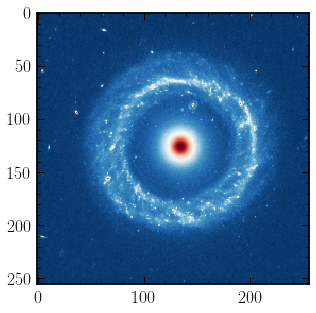

In [194]:
plt.imshow(im_source, cmap=cmap)

## NGC4414

In [195]:
galaxy_url = "https://cdn.spacetelescope.org/archives/images/screen/potw2015a.jpg"
galaxy_name = "NGC2906"

In [196]:
im_source

array([[0.00784314, 0.01020221, 0.016322  , ..., 0.02266481, 0.01434536,
        0.01908701],
       [0.00365403, 0.00582874, 0.00916054, ..., 0.01249234, 0.00905492,
        0.01165748],
       [0.00742098, 0.00813916, 0.00573234, ..., 0.01782191, 0.00496054,
        0.01801381],
       ...,
       [0.01124387, 0.01494332, 0.0104473 , ..., 0.01151512, 0.00754712,
        0.01494332],
       [0.00784314, 0.00985754, 0.01108799, ..., 0.00459828, 0.00784314,
        0.01176471],
       [0.01684283, 0.01868107, 0.016322  , ..., 0.00323989, 0.01278286,
        0.01176471]])

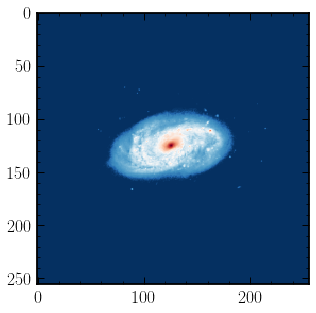

In [197]:
request.urlretrieve(galaxy_url, "{}.jpg".format(galaxy_name))
im_source = np.asarray(Image.open("{}.jpg".format(galaxy_name)).convert('L'))
im_source = im_source / np.max(im_source)
im_source = np.pad(im_source, (512, 512))
im_source[im_source < 0.15 * np.max(im_source)] = 0.
im_source = im_source[:,int((im_source.shape[1] - im_source.shape[0]) / 2):-int((im_source.shape[1] - im_source.shape[0]) / 2)]
im_source = resize(im_source, (n_xy, n_xy), anti_aliasing=True)
plt.imshow(im_source , cmap=cmap)

In [198]:
# # Lensed image

# lens_list = [hst_param_dict]
        
# lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
# image = lsi.lensed_image()

# plt.imshow(image)

In [199]:
std_noise = 0.02

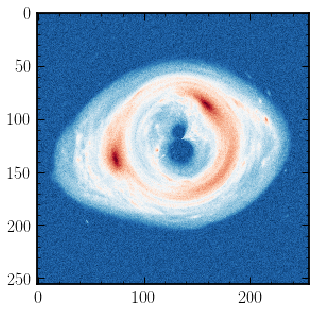

In [205]:
# Change the lens position

src_param_dict = {"profile": "CartesianGrid", "src_ary": im_source} 
hst_param_dict = {"profile": "SIE", "theta_x_0": -0.2, "theta_y_0": 0.2, "theta_E": 1.5, "q": 0.75}

lens_list = [hst_param_dict]
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image = lsi.lensed_image() 
image += std_noise * np.random.randn(*image.shape)

plt.imshow(image.T, cmap=cmap)

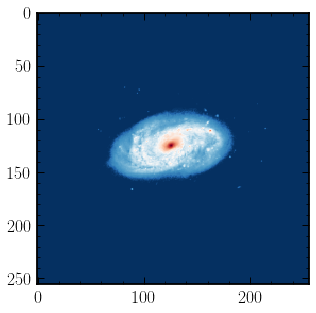

In [206]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
image_nolens = jnp.nan_to_num(lsi.lensed_image())

plt.imshow(image_nolens.T, cmap=cmap)

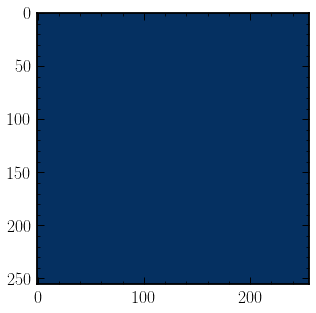

In [207]:
# Unlense image---just don't add a lens

lens_list = []  # No lens
        
lsi = LensingSim(lens_list, [], global_dict, observation_dict)
image_nosrc = lsi.lensed_image()

plt.imshow(image_nosrc, cmap=cmap)

In [208]:
np.mean(image_nolens - image_nosrc), np.std(image_nolens - image_nosrc)

(DeviceArray(0.02545739, dtype=float64),
 DeviceArray(0.08930724, dtype=float64))

## Custom source

In [209]:
import sys
sys.path.append("../")

from lensing_sim.profiles import LightProfileSersic

In [210]:
from jax import vmap, jit
from einops import rearrange, repeat

In [211]:
# Lensed image

def render_lens(inputs):
    lens_list = [hst_param_dict]
    src_param_dict = {"profile": "CartesianGrid", "src_ary": inputs}    

    lsi = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
    image = lsi.lensed_image()
    
    return image


# image = render_lens(inputs)

# plt.imshow(image)

In [212]:
theta_x_lims = theta_y_lims = [-1.5, 1.5]
n_x = n_y = n_xy

theta_x, theta_y = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_x), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_y))

inputs = LightProfileSersic(x_0=0.3, y_0=0., S_tot=5., r_e=1., n_srsc=4,).flux(theta_x, theta_y)

In [213]:
render_lens_vmapped = vmap(jit(render_lens))

## NeRF

In [214]:
def positional_encoding(inputs, positional_encoding_dims=10):
    batch_size, _ = inputs.shape
    inputs_freq = jax.vmap(
        lambda x: inputs * 2.0 ** x
    )(jnp.arange(positional_encoding_dims))
    periodic_fns = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    periodic_fns = periodic_fns.swapaxes(0, 2).reshape([batch_size, -1])
    periodic_fns = jnp.concatenate([inputs, periodic_fns], axis=-1)
    return periodic_fns

In [215]:
from typing import Any

import jax
import flax
import optax
from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

In [216]:
num_dense_layers = 8
dense_layer_width = 512
add_positional_encoding = True
add_skip_connection = True

In [217]:
class NeRFModel(nn.Module):
    dtype: Any = jnp.float32

    @nn.compact
    def __call__(self, input_points):
        for i in range(num_dense_layers):
            # Apply positional encoding to the input points
            
            if add_positional_encoding:
                x = positional_encoding(input_points)
            else:
                x = input_points
                                    
            # Fully-connected layer
            x = nn.Dense(
                dense_layer_width,
                dtype=self.dtype,
            )(x)
                        
            # Activation function
            x = nn.relu(x)
            
            if add_skip_connection: # Skip connection
                x = jnp.concatenate([x, input_points], axis=-1) if i in [4] else x

        x = nn.Dense(2, dtype=self.dtype)(x)
        return x


In [218]:
def initialize_model(key, input_pts_shape):
    # Create an instance of the model
    model = NeRFModel()

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [219]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(43))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

In [220]:
# input_to_network = jnp.ones((1, 2 * n_xy * n_xy))
input_to_network = jnp.ones((n_xy * n_xy, 2))

In [221]:
model.apply({"params": params}, input_to_network).shape

(65536, 2)

In [222]:
"The model has {} parameters".format(sum(x.size for x in jax.tree_leaves(params)))

'The model has 177154 parameters'

In [223]:
theta_x_lims = theta_y_lims = [-1., 1.]
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)
# image_input =  jax.scipy.special.logit(nn.sigmoid(jnp.expand_dims(image, 0)))

# image_input

In [224]:
# model_fn = lambda x: model.apply({"params": params}, x)
# # model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = model_fn(rearrange(coords, "c h w -> (h w) c"))
# model_output = rearrange(model_output, "(h w) 1 -> 1 h w", h=n_xy, w=n_xy)

# lenses = render_lens_vmapped(model_output)

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

# epoch = -1

# ax1.imshow(model_output[0], cmap=cmap, vmin=0, vmax=1)
# ax1.set_title(f"Predicted source at epoch {epoch}")
# ax1.axis("off")
# ax2.imshow(mnist_resized, cmap=cmap, vmin=0, vmax=1)
# ax2.set_title(f"True source")
# ax2.axis("off")
# ax3.imshow(lenses[0].T, cmap=cmap)
# ax3.set_title(f"Predicted lensed image at epoch {epoch}")
# ax3.axis("off")
# ax4.imshow(image_input[0].T, cmap=cmap)
# ax4.set_title(f"True lensed image")
# ax4.axis("off")
# plt.show()

In [225]:
n_q_samples = 128

In [226]:
import distrax

In [227]:
import functools

@functools.partial(jax.jit, static_argnums=3)
def train_step(state, batch, key, learning_rate_fn):
    """Train Step"""
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
                       
    # Compute the loss in a stateless manner
    def loss_fn(params):
        # Create the model function from the train state
        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output = model_fn(inputs)
        model_output = rearrange(model_output, "(h w) mus -> mus (h w)", h=n_xy, w=n_xy)
        
        mu = jnp.exp(model_output[0])
        sigma = jnp.sqrt(jnp.exp(model_output[1]))
        
        # dist_distrax = distrax.Normal(0, 1)
        dist_distrax = distrax.Normal(mu, sigma)
        dist_prior = distrax.Normal(0.5, 3)
        
        samples, loss_q = dist_distrax.sample_and_log_prob(seed=key, sample_shape=(n_q_samples,))

        # samples = repeat(samples, 'n_samp -> n_samp hw', hw=n_xy * n_xy)
        # samples = samples * sigma + mu
        
        # loss_q = jnp.mean(.5 * (1 + jnp.log(sigma ** 2) - mu ** 2 - sigma ** 2)) 
        loss_q = jnp.mean(loss_q)
        loss_prior = -jnp.mean(dist_prior.log_prob(samples))
        
        samples = rearrange(samples, "s (h w) -> s h w", h=n_xy, w=n_xy)

        lenses = render_lens_vmapped(samples)
                
        # Compute mean-squared error
        loss_mse = jnp.mean((lenses - targets) ** 2 / std_noise ** 2) 
        
        # print(loss_mse, loss_q, jnp.mean(dist_prior.log_prob(samples)))
              
        return loss_mse + loss_q + loss_prior
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    # Updated the model params and the optimizer state
    new_state = state.apply_gradients(grads=gradients)
    # Mean of train loss of the batch
    train_loss = jnp.mean(train_loss)
    # Compute PSNR
    train_psnr = -10.0 * jnp.log(train_loss) / jnp.log(10.0)
    
    lr = learning_rate_fn(state.step)
    
    return train_loss, train_psnr, new_state

In [230]:
learning_rate_init = 1e-4
learning_rate_peak = 1e-3
warmup_fraction_steps = 0.1
weight_decay = 1e-4
momentum = 0.8
optimizer_name = "adamw"

In [231]:
train_epochs = 25000
plot_every = 500

In [232]:
from flax.training.lr_schedule import create_cosine_learning_rate_schedule

lr_schedule = optax.warmup_cosine_decay_schedule(init_value=learning_rate_init, 
                                                 peak_value=learning_rate_peak, 
                                                 warmup_steps=int(warmup_fraction_steps * train_epochs), 
                                                 decay_steps=train_epochs - int(warmup_fraction_steps * train_epochs), 
                                                 end_value=0.0)

In [233]:
coords.shape, image_input.shape

((2, 256, 256), (1, 256, 256))

In [234]:
from celluloid import Camera
show_maps = False

# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))

# Initialize the Model
model, params = initialize_model(key, (n_xy * n_xy, 2))

# Define the Optimizer
if optimizer_name == "adamw":
    optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=weight_decay)
elif optimizer_name == "sgdm":
    optimizer = optax.sgd(learning_rate=lr_schedule, momentum=momentum, nesterov=True)
elif optimizer_name == "adabelief":
    optimizer = optax.adabelief(learning_rate=lr_schedule)
else:
    raise NotImplementedError
    
# Create the Training State
state = train_state.TrainState.create(
    apply_fn=model.apply, params=params, tx=optimizer
)


# Function for executing the train and validation loop
def train_and_evaluate(state, train_step_fn, learning_rate_fn):
        
    train_loss_history, train_psnr_history, reconstructed_src_mu_history, reconstructed_src_std_history, reconstructed_lens_history = [], [], [], [], []
    
    key, rng = jax.random.split(jax.random.PRNGKey(np.random.randint(1000)))
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        key, rng = jax.random.split(key)
        train_loss, train_psnr, state = train_step_fn(state, train_batch, key, learning_rate_fn)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))
        train_psnr_history.append(np.asarray(np.mean(train_psnr)))

        # Plot the result every plot interval
        if epoch % plot_every == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) c -> c h w", h=n_xy, w=n_xy)
                        
            lenses = render_lens(jnp.exp(model_output[0]))
            
            reconstructed_lens_history.append(np.asarray(lenses.T))
            reconstructed_src_mu_history.append(np.asarray(model_output[0]))
            reconstructed_src_std_history.append(np.asarray(model_output[1]))
            
            if show_maps:
                
                print(np.asarray(np.mean(train_loss)))
                
                fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 4))

                ax1.imshow(model_output[0], cmap=cmap, vmin=0, vmax=1)
                ax1.set_title(f"Predicted source at epoch {epoch}")
                ax1.axis("off")
                ax2.imshow(im_source, cmap=cmap, vmin=0, vmax=1)
                ax2.set_title(f"True source")
                ax2.axis("off")
                ax3.imshow(lenses.T, cmap=cmap)
                ax3.set_title(f"Predicted lensed image at epoch {epoch}")
                ax3.axis("off")
                ax4.imshow(image_input[0].T, cmap=cmap)
                ax4.set_title(f"True lensed image")
                ax4.axis("off")
                im = ax5.imshow((lenses.T - image_input[0].T), cmap=cmap)
                ax5.set_title(f"Residual")
                ax5.axis("off")
                cbar = fig.colorbar(im, ax=ax5, extend='both')
                plt.show()
    
    hist = {
        "train_loss": train_loss_history,
        "train_psnr": train_psnr_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src_mu": reconstructed_src_mu_history,
        "reconstructed_src_std": reconstructed_src_std_history
    }
    
    return state, hist

In [235]:
state, hist = train_and_evaluate(state, train_step, lr_schedule)

100%|██████████| 25000/25000 [03:58<00:00, 105.03it/s]


In [236]:
# np.array(hist["reconstructed_src_mu"])[:, 0, 0]

In [237]:
# np.exp(np.array(hist["reconstructed_src_std"]))[:, 32, 32]

In [238]:
sigma = np.sqrt(np.exp(np.array(hist["reconstructed_src_std"]))[-1, :])
np.mean(sigma[sigma < 0.2])

0.020277439

In [239]:
std_noise

0.02

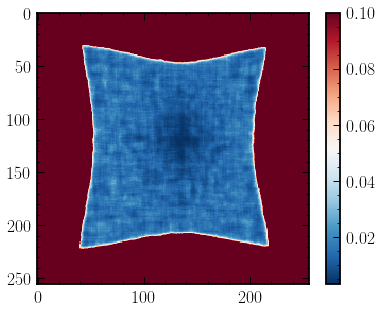

In [240]:
im = plt.imshow(np.sqrt(np.exp(np.array(hist["reconstructed_src_std"]))[-1, :]), cmap=cmap, vmax=0.1)
cbar = plt.colorbar(im, ax=plt.gca())

In [241]:
from scipy.ndimage import gaussian_filter

In [242]:
from lensing_sim.profiles import MassProfileSIE
from lensing_sim.units import asctorad

x_d, y_d = MassProfileSIE(x_0=hst_param_dict["theta_x_0"] * lsi.D_l * asctorad,
                y_0=hst_param_dict["theta_y_0"] * lsi.D_l * asctorad,
                r_E=hst_param_dict["theta_E"] * lsi.D_l * asctorad,
                q=hst_param_dict["q"],
                ).deflection(lsi.x, lsi.y)

In [243]:
oob_cond = ((lsi.x + x_d) > np.max(lsi.x)) + ((lsi.x + x_d) < np.min(lsi.x)) + \
((lsi.y + y_d) > np.max(lsi.y)) + ((lsi.y + y_d) < np.min(lsi.y))

In [262]:
pixmax_cond = im_source < 0.01 * im_source.max()

In [263]:
# np.exp(hist["reconstructed_src_mu"][-1][~oob_cond])

In [264]:
# im_source[~oob_cond]

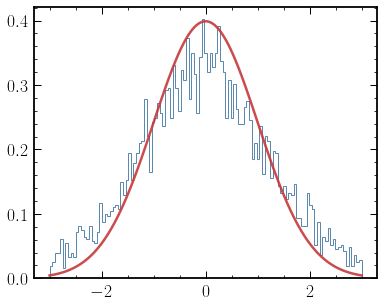

In [268]:
from scipy.stats import norm

x_bins = np.linspace(-3, 3, 120)
z_sc = (np.exp(hist["reconstructed_src_mu"][-1][~pixmax_cond]) - im_source[~pixmax_cond]) / std_noise
z_sc = (np.exp(hist["reconstructed_src_mu"][-1][~pixmax_cond]) - im_source[~pixmax_cond]) / np.sqrt(np.exp(hist["reconstructed_src_std"])[-1][~pixmax_cond])

plt.plot(x_bins, norm.pdf(x_bins))
plt.hist(z_sc, bins=x_bins, histtype='step', density=True);

In [269]:
# plt.plot((np.exp(hist["reconstructed_src_mu"][-1][~oob_cond]) - im_source[~oob_cond]) / np.sqrt(np.exp(hist["reconstructed_src_std"])[-1][~oob_cond]))
# plt.plot((np.exp(hist["reconstructed_src_mu"][-1][~oob_cond]) - im_source[~oob_cond]) / std_noise)

In [270]:
# plt.plot(np.exp(hist["reconstructed_src_mu"][-1][~oob_cond]).T.flatten(), lw=0.3)
# plt.plot(im_source[~oob_cond],  lw=0.3)

(-1.0, 10.0)

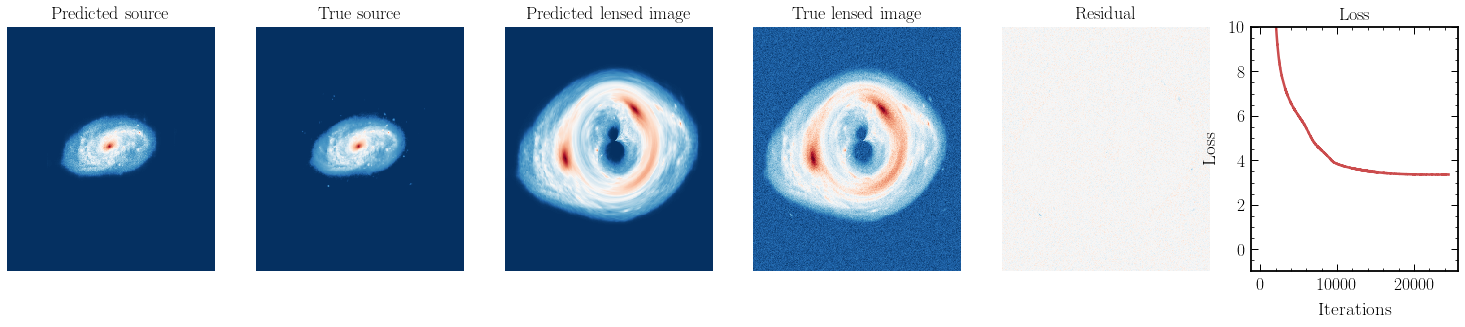

In [271]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(26, 4.5))

i = len(hist["reconstructed_src_mu"]) - 1

ax1.imshow(np.exp(hist["reconstructed_src_mu"][i]) * ~oob_cond, cmap=cmap, vmin=0, vmax=1, aspect="auto")
# ax1.imshow(gaussian_filter(hist["reconstructed_src_mu"][i] * ~oob_cond, sigma=0.025 / pixel_size, truncate=8.), cmap=cmap, vmin=0, vmax=1, aspect="auto")
ax1.set_title(f"Predicted source")
ax1.axis("off")
ax2.imshow(im_source * ~oob_cond, cmap=cmap, vmin=0, vmax=1, aspect="auto")
ax2.set_title(f"True source")
ax2.axis("off")
ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
ax3.set_title(f"Predicted lensed image")
ax3.axis("off")
ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
ax4.set_title(f"True lensed image")
ax4.axis("off")
# im = ax5.imshow((hist["reconstructed_src_mu"][i] - mnist_resized) / np.sqrt(np.exp(hist["reconstructed_src_std"][i])), cmap=cmap, vmin=-3, vmax=3)
im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T), cmap=cmap, aspect="auto", vmin=-0.5, vmax=0.5)
ax5.set_title(f"Residual")
ax5.axis("off")
ax6.plot(np.arange(plot_every * (i)), hist["train_loss"][:plot_every * (i)], color=cols_default[0])
ax6.set_title(f"Loss")
ax6.set_xlabel(f"Iterations")
ax6.set_ylabel(f"Loss")
ax6.set_ylim(-1, 10.)

In [272]:
hist["train_loss"][-1]

array(3.36138056)

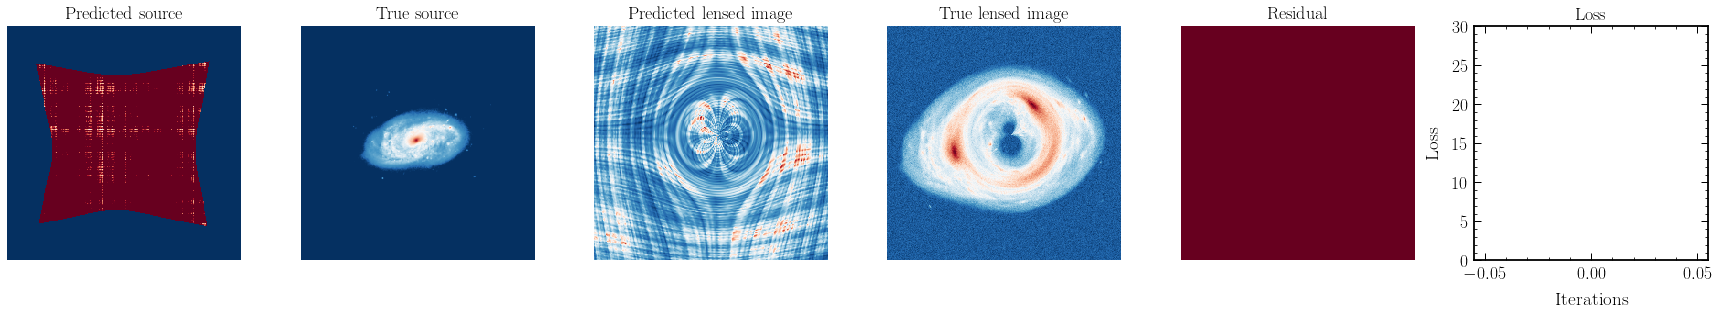

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

In [273]:
epoch = -1

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4.5))
camera = Camera(fig)

for i in range(len(hist["reconstructed_lens"])):
    ax1.imshow(np.exp(hist["reconstructed_src_mu"][i]) * ~oob_cond, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax1.set_title(f"Predicted source")
    ax1.axis("off")
    ax2.imshow(im_source * ~oob_cond, cmap=cmap, vmin=0, vmax=1, aspect="auto")
    ax2.set_title(f"True source")
    ax2.axis("off")
    ax3.imshow(hist["reconstructed_lens"][i], cmap=cmap, aspect="auto")
    ax3.set_title(f"Predicted lensed image")
    ax3.axis("off")
    ax4.imshow(image_input[0].T, cmap=cmap, aspect="auto")
    ax4.set_title(f"True lensed image")
    ax4.axis("off")
    # im = ax5.imshow((hist["reconstructed_src_mu"][i] - mnist_resized) / np.sqrt(np.exp(hist["reconstructed_src_std"][i])), cmap=cmap, vmin=-3, vmax=3)
    im = ax5.imshow((hist["reconstructed_lens"][i] - image_input[0].T), cmap=cmap, aspect="auto", vmin=-.1, vmax=.1)
    ax5.set_title(f"Residual")
    ax5.axis("off")
    ax6.plot(np.arange(plot_every * (i)), hist["train_loss"][:plot_every * (i)], color=cols_default[0])
    ax6.set_title(f"Loss")
    ax6.set_xlabel(f"Iterations")
    ax6.set_ylabel(f"Loss")
    ax6.set_ylim(0, 30.)
    # cbar = fig.colorbar(im, ax=ax5)
    plt.tight_layout();
    plt.show()
    camera.snap()

In [274]:
animation = camera.animate()
animation.save('render.gif', fps=7)

(0.0, 30.0)

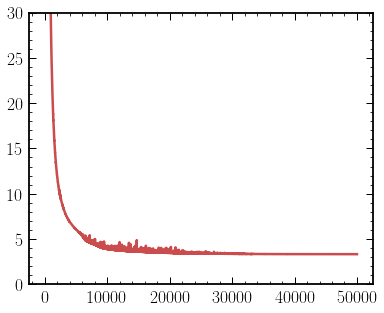

In [583]:
plt.plot(hist["train_loss"])
# plt.plot(hist["train_psnr"])
plt.ylim(0, 30)

In [128]:
# model_fn = lambda x: state.apply_fn({"params": state.params}, x)
# model_output = model_fn(rearrange(coords, "c h w -> 1 (c h w)"))
# model_output = rearrange(model_output, "1 (h w) -> 1 h w", h=n_xy, w=n_xy)
# plt.imshow(model_output[0])

## Flow experiments 

In [86]:
import distrax

key = jax.random.PRNGKey(1234)

mu = jnp.array([-1., 2.])
sigma = jnp.array([0.1, 0.2])

dist_distrax = distrax.Normal(mu, sigma)

samples = dist_distrax.sample(seed=key, sample_shape=(64,))

samples.shape

(64, 2)

In [87]:
dist_distrax.log_prob(samples).mean()

DeviceArray(0.51576647, dtype=float64)

In [107]:
class SimpleMLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i, feat in enumerate(self.features):
            x = nn.Dense(feat, name=f'layers_{i}')(x)
            if i != len(self.features) - 1:
                x = nn.relu(x)
                # providing a name is optional though!
                # the default autonames would be "Dense_0", "Dense_1", ...
        return x

key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.uniform(key1, (4,4))

model = SimpleMLP(features=[3,4,5])
params = model.init(key2, x)
y = model.apply(params, x)

In [108]:
y.shape

(4, 5)

In [112]:
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple


# def make_conditioner(event_shape: Sequence[int],
#                      hidden_sizes: Sequence[int],
#                      num_bijector_params: int) -> nn.Module:
#     """Creates an MLP conditioner for each layer of the flow."""
#     return hk.Sequential([
#       hk.Flatten(preserve_dims=-len(event_shape)),
#       hk.nets.MLP(hidden_sizes, activate_final=True),
#       # We initialize this linear layer to zero so that the flow is initialized
#       # to the identity function.
#       hk.Linear(
#           np.prod(event_shape) * num_bijector_params,
#           w_init=jnp.zeros,
#           b_init=jnp.zeros),
#       hk.Reshape(tuple(event_shape) + (num_bijector_params,), preserve_dims=-1),
#     ])

Array = jnp.ndarray

def make_flow_model(event_shape: Sequence[int],
                    num_layers: int,
                    hidden_sizes: Sequence[int],
                    num_bins: int) -> distrax.Transformed:
    """Creates the flow model."""
    # Alternating binary mask.
    mask = jnp.arange(0, np.prod(event_shape)) % 2
    mask = jnp.reshape(mask, event_shape)
    mask = mask.astype(bool)

    def bijector_fn(params: Array):
        return distrax.(
            params, range_min=0., range_max=1.)

    # Number of parameters for the rational-quadratic spline:
    # - `num_bins` bin widths
    # - `num_bins` bin heights
    # - `num_bins + 1` knot slopes
    # for a total of `3 * num_bins + 1` parameters.
    num_bijector_params = 3 * num_bins + 1
    
    conditioner = SimpleMLP(features=[64,64, event_shape[0] + num_bijector_params])
    
    x = jax.random.uniform(key, (3, 1))
    params = conditioner.init(key, x)
    conditioner_fn = lambda inputs: conditioner.apply(params, inputs)

    layers = []
    for _ in range(num_layers):
        layer = distrax.MaskedCoupling(
            mask=mask,
            bijector=bijector_fn,
            # conditioner=make_conditioner(event_shape, hidden_sizes, num_bijector_params))
            conditioner=conditioner_fn)
            
        layers.append(layer)
        # Flip the mask after each layer.
        mask = jnp.logical_not(mask)

    # We invert the flow so that the `forward` method is called with `log_prob`.
    flow = distrax.Inverse(distrax.Chain(layers))
    base_distribution = distrax.Independent(
      distrax.Uniform(
          low=jnp.zeros(event_shape),
          high=jnp.ones(event_shape)),
      reinterpreted_batch_ndims=len(event_shape))

    return distrax.Transformed(base_distribution, flow)

flow_model = make_flow_model(event_shape=[1], num_layers=4, hidden_sizes=[64,64], num_bins=3)
flow_model.sample(seed=key)

ValueError: The last dimension of `params` must have size `3 * num_bins + 1` and `num_bins` must be at least 1. Got size 11.

In [84]:
# sys.path.append("../../jax-flows/")
# sys.path.append("../../")

# import flows

# num_blocks = 4

# modules = []
# for _ in range(num_blocks):
#     modules += [
#         flows.NeuralSplineCoupling(),
#     ]
    
# bijection = flows.Serial(*tuple(modules))
# prior = flows.Normal()

# init_fun = flows.Flow(bijection, prior)
# params, log_pdf, sample = init_fun(key, 2)

# inputs = jnp.ones((64, 2))
# # -log_pdf(params, inputs).mean()